In [126]:
!pip install wget
!pip install spacy
!pip install gensim
!pip install pyspellchecker
!pip install transformers
!pip install wordcloud

In [127]:
# !wget -O data.csv https://www.dropbox.com/s/xd35vnpmi2f5gdb/2016_US_election_tweets_100k.csv?dl=0
!wget -O data.zip "https://www.dropbox.com/s/szuhoq38fk82u5n/hw2_data.zip?dl=0"
!rm -rf Data_file
!unzip data.zip

--2021-04-09 12:51:53--  https://www.dropbox.com/s/szuhoq38fk82u5n/hw2_data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:601f:18::a27d:912, 162.125.9.18
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:601f:18::a27d:912|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/szuhoq38fk82u5n/hw2_data.zip [following]
--2021-04-09 12:51:53--  https://www.dropbox.com/s/raw/szuhoq38fk82u5n/hw2_data.zip
Reusing existing connection to [www.dropbox.com]:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce9abebe00d86efc0ec40021f1d.dl.dropboxusercontent.com/cd/0/inline/BMTB1sFFl8vBRyf9j8Q0SXw_euRROQY-Ufbo8lA3b6V7KdTf7B8Xh8Vruqf45FGkHgPCi_BOax5hcSb7HcIO0s_3Q5peWk6Akxjk8TCe-Bueiw9pNmDaOxbX9m2EaFet-4i3L0UA7bBKMBxbzfYIMaY0/file# [following]
--2021-04-09 12:51:54--  https://uce9abebe00d86efc0ec40021f1d.dl.dropboxusercontent.com/cd/0/inline/BMTB1sFFl8vBRyf9j8Q0SXw_euRROQY-Ufbo8lA3b6V7KdTf7B8Xh8Vruqf45FGkHgPCi

In [128]:
import multiprocessing
import re
import string
import csv
import urllib.request

from spellchecker import SpellChecker
import pandas as pd
import numpy as np

import spacy

import nltk;
from nltk.corpus import stopwords
nltk.download('stopwords')

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

from transformers import AutoModelForSequenceClassification, AutoTokenizer
from scipy.special import softmax

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dipta007/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [129]:
# dfs = []
# for i in range(1, 6):
#   df = pd.read_csv(f'./Data_file/#longcovid{i}.csv', header=None, names=['data', 'tweet_text'])
#   dfs.append(df)

# df = pd.concat(dfs)

df = pd.read_csv('./out_wo_spell_lemm.csv')

df.head()

,Unnamed: 0,data,tweet_text
0,0,2020-11-23,Back in bed with pneumonia symptoms Doctor s appointment over zoom tomorrow because they cannot test me at the GP s office or at home Covid really is the gift that keeps on giving All of this 85 months after infection LongCovid
1,1,2020-11-23,Graded exercise is not the correct advice for LongCovid
2,2,2020-11-23,Second Vitamin D clinical trial positive results via YouTube PostCovidSynd COVID19 LongCovid coronavirus
3,3,2020-11-23,Graded exercise being advised for those with LongCovid worryingly it says the article is Brought to you by the UK Government NHSEngland Telegraph this is completely wrong advice
4,4,2020-11-23,Tonight 60Minutes will be featuring a story on LongCovid LongHaulers or Post Acute Covid Syndrome as the medical community is now calling it Promises to be an interesting show Covid19 🦠


In [130]:
df = df.dropna(subset=['tweet_text'])

In [131]:
def preprocess(text):
    new_text = []


    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [132]:
df['tweet_text'] = df['tweet_text'].apply(preprocess)

In [133]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

def get_model_tokenizer():
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL)
    model.save_pretrained(MODEL)
    
    return model, tokenizer

In [134]:
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

print(labels)

['negative', 'neutral', 'positive']


In [135]:
!rm -rf cardiffnlp 
model, tokenizer = get_model_tokenizer()

In [136]:
text = "Good night 😊"
text = preprocess(text)
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

In [137]:
scores

array([0.00760987, 0.14581203, 0.8465782 ], dtype=float32)

In [138]:
np.argsort(scores)[::-1]

array([2, 1, 0])

In [139]:
def get_result(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    return labels[ranking[0]]

In [140]:
df.head()

,Unnamed: 0,data,tweet_text
0,0,2020-11-23,Back in bed with pneumonia symptoms Doctor s appointment over zoom tomorrow because they cannot test me at the GP s office or at home Covid really is the gift that keeps on giving All of this 85 months after infection LongCovid
1,1,2020-11-23,Graded exercise is not the correct advice for LongCovid
2,2,2020-11-23,Second Vitamin D clinical trial positive results via YouTube PostCovidSynd COVID19 LongCovid coronavirus
3,3,2020-11-23,Graded exercise being advised for those with LongCovid worryingly it says the article is Brought to you by the UK Government NHSEngland Telegraph this is completely wrong advice
4,4,2020-11-23,Tonight 60Minutes will be featuring a story on LongCovid LongHaulers or Post Acute Covid Syndrome as the medical community is now calling it Promises to be an interesting show Covid19 🦠


In [142]:
df['output'] = df['tweet_text'].apply(get_result)

In [143]:
df.head()

,Unnamed: 0,data,tweet_text,output
0,0,2020-11-23,Back in bed with pneumonia symptoms Doctor s appointment over zoom tomorrow because they cannot test me at the GP s office or at home Covid really is the gift that keeps on giving All of this 85 months after infection LongCovid,negative
1,1,2020-11-23,Graded exercise is not the correct advice for LongCovid,negative
2,2,2020-11-23,Second Vitamin D clinical trial positive results via YouTube PostCovidSynd COVID19 LongCovid coronavirus,positive
3,3,2020-11-23,Graded exercise being advised for those with LongCovid worryingly it says the article is Brought to you by the UK Government NHSEngland Telegraph this is completely wrong advice,negative
4,4,2020-11-23,Tonight 60Minutes will be featuring a story on LongCovid LongHaulers or Post Acute Covid Syndrome as the medical community is now calling it Promises to be an interesting show Covid19 🦠,positive


In [144]:
pd.set_option('display.max_colwidth', -1)

/home/dipta007/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [145]:
df.to_csv('sentiment_after_preprocess.csv')

In [146]:
df.head(20)

,Unnamed: 0,data,tweet_text,output
0,0,2020-11-23,Back in bed with pneumonia symptoms Doctor s appointment over zoom tomorrow because they cannot test me at the GP s office or at home Covid really is the gift that keeps on giving All of this 85 months after infection LongCovid,negative
1,1,2020-11-23,Graded exercise is not the correct advice for LongCovid,negative
2,2,2020-11-23,Second Vitamin D clinical trial positive results via YouTube PostCovidSynd COVID19 LongCovid coronavirus,positive
3,3,2020-11-23,Graded exercise being advised for those with LongCovid worryingly it says the article is Brought to you by the UK Government NHSEngland Telegraph this is completely wrong advice,negative
4,4,2020-11-23,Tonight 60Minutes will be featuring a story on LongCovid LongHaulers or Post Acute Covid Syndrome as the medical community is now calling it Promises to be an interesting show Covid19 🦠,positive
5,5,2020-11-23,Back in bed with pneumonia symptoms Doctor s appointment over zoom tomorrow because they cannot test me at the GP s office or at home Covid really is the gift that keeps on giving All of this 85 months after infection LongCovid,negative
6,6,2020-11-23,ePatientDave ahandvanish SaraAssaf Thanks for sharing Many of our itsbodypolitic patients have gotten creative with tracking especially in the acute phase of infection Although longcovid is a whole other beast we need systemic solutions to countlongcovid See discussions under here,positive
7,7,2020-11-23,this is awe inspiring More women in science please Plus over 8 months after having it I am still ill with LongCovid symptoms I hope people take up the opportunity to be vaccinated and avoid this rubbish illness Immunity by other means is too risky,negative
8,8,2020-11-23,Is it just me or is there a seemingly active public and professional disassociation by the media and the medical field etc between LongCovid and post viral MECFS I feel like many not all are deliberately ignoring the long standing data and drawing parallels Am I wrong,negative
9,9,2020-11-23,fiski70 babyowlpink lewbloch LordDrakulzen Yeshuaprovida Jackaltwinky77 th1rt3enTM MalevolenceInc1 DanaMcwhitee BrunTheBear pnschwartz kross69 thegodsareangry I wear my mask because I know I could be sick without knowing it and I do not want to make others sick with something that could kill them or that they could spread to others who might die Or suffer organ damage Or be stuck with LongCovid,negative


In [147]:
df = pd.read_csv('sentiment_after_preprocess.csv')

In [148]:
df.head()

,Unnamed: 0,Unnamed: 0.1,data,tweet_text,output
0,0,0,2020-11-23,Back in bed with pneumonia symptoms Doctor s appointment over zoom tomorrow because they cannot test me at the GP s office or at home Covid really is the gift that keeps on giving All of this 85 months after infection LongCovid,negative
1,1,1,2020-11-23,Graded exercise is not the correct advice for LongCovid,negative
2,2,2,2020-11-23,Second Vitamin D clinical trial positive results via YouTube PostCovidSynd COVID19 LongCovid coronavirus,positive
3,3,3,2020-11-23,Graded exercise being advised for those with LongCovid worryingly it says the article is Brought to you by the UK Government NHSEngland Telegraph this is completely wrong advice,negative
4,4,4,2020-11-23,Tonight 60Minutes will be featuring a story on LongCovid LongHaulers or Post Acute Covid Syndrome as the medical community is now calling it Promises to be an interesting show Covid19 🦠,positive


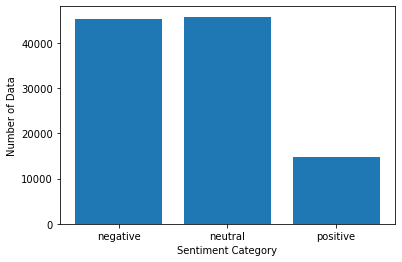

45260 45746 14815


In [149]:
bins = { 0: 0, 1: 0, 2: 0}

for index, row in df.iterrows():
    ind = labels.index(row['output'])
    bins[ind] += 1

import matplotlib.pyplot as plt
%matplotlib inline

x = np.arange(3)
plt.bar(x, height=[bins[0], bins[1], bins[2]])
plt.xticks(x, [labels[0], labels[1], labels[2]])

plt.ylabel('Number of Data')
plt.xlabel('Sentiment Category')
plt.savefig('./figs2/sentiment_hist.png')
plt.show()

print(bins[0], bins[1], bins[2])

In [150]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

def get_word_cloud(category):
    positive_texts = [row['tweet_text'] for ind, row in df.iterrows() if row['output'] == category]
    text = " ".join(positive_texts)

    # Create and generate a word cloud image:
    stopwords = set(STOPWORDS)
    stopwords.update(['LongCovid', 'Long Covid', 'need', 'will', 'know', 'see'])
    wordcloud = WordCloud(width=1280,
                          height=720,
                          max_words=100,
                          stopwords=stopwords,
                          background_color='white'
                         ).generate(text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
    wordcloud.to_file(f"figs2/{category}.png")

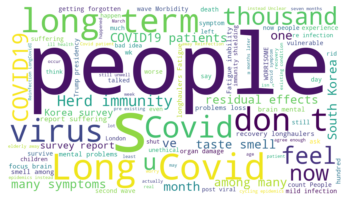

('negative', None)

In [151]:
labels[0], get_word_cloud(labels[0])

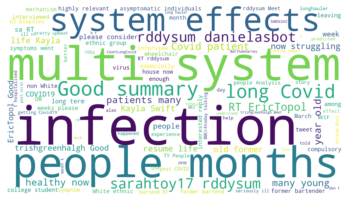

('neutral', None)

In [152]:
labels[1], get_word_cloud(labels[1])

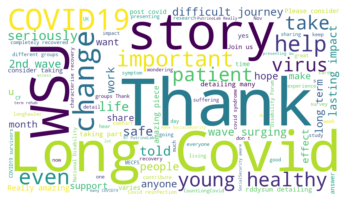

('positive', None)

In [153]:
labels[2], get_word_cloud(labels[2])